MISSING RATES: [0.5]


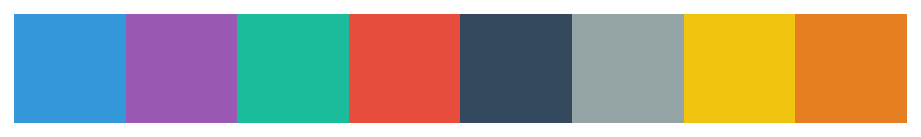

In [1]:
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use("seaborn-poster") ### Use this for figures used in posters
# plt.style.use("seaborn-paper") ### Use this for figures used in paper
# plt.style.use("seaborn-talk") ### Use this for figures used in presentations/talks
import scipy.misc
from sargan_models import SARGAN
from utils import imsave
import tensorflow as tf
import numpy as np
import time
import sys
from tqdm import tqdm
from sar_utilities import to_dB, visualize_raw_data, get_spectrum, \
    visualize_raw_data_spectrum, insert_freq_gaps, \
    generate_raw_data_from_dict, downsample, snr, \
    add_gaussian_noise, preprocess_train, preprocess_test, \
    generate_raw_data
import math
from alert_utilities import send_images_via_email
import time
import scipy.io as sio
%matplotlib inline
%config InlineBackend.figure_format = "retina"

mpl.rcParams["axes.grid"] = False
mpl.rcParams["grid.color"] = "#f5f5f5"
mpl.rcParams["axes.facecolor"] = "#ededed"
mpl.rcParams["axes.spines.left"] = False
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.bottom"] = False
mpl.rcParams['axes.labelcolor'] = "grey"
mpl.rcParams['xtick.color'] = 'grey'
mpl.rcParams['ytick.color'] = 'grey'
mpl.rcParams["figure.figsize"] = [4, 3]
from cycler import cycler
import seaborn as sns
# color_palette = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
# color_palette = sns.color_palette("deep", 10)
# color_palette = sns.color_palette("Set1")
color_palette = ["#3498db", "#9b59b6", "#1abc9c", "#e74c3c", "#34495e", "#95a5a6", "#f1c40f", "#e67e22"]
sns.palplot(color_palette)
sns.set_context("paper")
mpl.rcParams["axes.prop_cycle"] = cycler('color', color_palette)

import pickle

DATA_PATH = "/data/dung/sargan"

scene_type = "uniform"

import os
scene_data_filename = "deterministic_scene_dict_atom_distance_20"
with open(os.path.join(DATA_PATH, scene_data_filename + ".pickle"), 'rb') as handle:
    sar_scene_data = pickle.load(handle)
scene_raw_data_mat = sar_scene_data["scene_raw_data_mat"]
scene_image = sar_scene_data["scene_image"]
ori_n_samples = sar_scene_data["n_samples"]
ori_n_apertures = sar_scene_data["n_apertures"]
sampling_period = sar_scene_data["transmistted_pulse_sample_period"]

scene_raw_data_batch = np.expand_dims(scene_raw_data_mat, axis=0)
downsample_factor = 4
DOWNSAMPLE = False
if DOWNSAMPLE:
    n_samples = math.ceil(ori_n_samples / downsample_factor)
    n_apertures = math.ceil(ori_n_apertures / downsample_factor)
else:
    n_samples = ori_n_samples
    n_apertures = ori_n_apertures
    
n_fft = ori_n_samples
sampling_freq = 1. / (sampling_period + 1e-32)
df = sampling_freq / n_fft
freq = [df*i / 1e9 for i in range(0, n_fft)]    

# freq_band = (380e6, 2080e6)
freq_band = (300e6, 3000e6)
freq_band_width = freq_band[1] - freq_band[0]
# missing_rates = np.asarray([0.5, 0.7, 0.9])
missing_rates = np.asarray([0.5, 0.6, 0.7, 0.8, 0.9])
missing_rates = np.asarray([0.5])
print("MISSING RATES:", missing_rates)
n_missing_rates = missing_rates.shape[0]
freq_gaps = []
for missing_rate in missing_rates:
    missing_band_width = round(freq_band_width * missing_rate)
    gap_width = missing_band_width
#     f_start = np.array([freq_band[0] + round(0.1*freq_band_width)])
    f_start = np.array([freq_band[0] + round(0.5 * (freq_band_width - missing_band_width))])
    f_end = f_start + gap_width
    f_start_idx = np.int_(np.ceil(f_start / df))
    f_end_idx = np.int_(np.ceil(f_end / df))
    freq_gap = [f_start_idx, f_end_idx]
    freq_gaps.append(freq_gap)

if DOWNSAMPLE:
    from sargan_config import ConfigDownsample as conf
else:
    from sargan_config import Config as conf

from sargan_config import Config as conf
    
img_size = (n_samples, n_apertures)
train_size = img_size
batch_size = conf.batch_size
img_channel = conf.img_channel
conv_channel_base = conf.conv_channel_base

learning_rate = conf.learning_rate
beta1 = conf.beta1
max_epoch = conf.max_epoch
L1_lambda = conf.L1_lambda
save_per_epoch = conf.save_per_epoch

trained_models_path = conf.trained_models_path
data_name = 'synthetic_sar'
# experiment_name = "freq_corrupted_real"
experiment_name = "freq_corrupted_real_fixed_sparsity_0_1_coef_range"

db_range = 20 # For visualizing raw dta

ori_color = color_palette[0]
corrupted_color = color_palette[1]
reconstructed_color = color_palette[2]
omp_color = color_palette[7]

float_type = np.float32
mat_file_name = "sar_dict_small"
sar_dict_data = sio.loadmat(os.path.join(DATA_PATH, mat_file_name + ".mat"))
sar_dict_mat = sar_dict_data["sar_dict"].astype(float_type)
transmitted_pulse = sar_dict_data["pulse"].astype(float_type)
transmistted_pulse_sample_period = sar_dict_data["pulse_sampling_period"][0][0].astype(float_type)

output_path = os.path.join(DATA_PATH, "radarconf19_paper/22074730sjjkfjywrsmx")

In [2]:
def run_omp_recovery(corrupted_data, pulse, freq_gap, n_nonzero_coefs):
    from sklearn.linear_model import OrthogonalMatchingPursuit
    from scipy.linalg import circulant
    
    D = circulant(processted_transmitted_pulse)
    D_batch = np.expand_dims(D, axis=0)
    D_gap, _ = insert_freq_gaps(D_batch, D.shape, freq_gap)
    D_gap = D_gap[0, :, :]

    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
#     omp.fit(D_gap, cond[0, :, :])
    omp.fit(D_gap, corrupted_data)
    coef = omp.coef_
#     omp_recontructed = np.roll(np.transpose(np.dot(coef, D)), 300, axis=0)
    omp_reconstructed = np.transpose(np.dot(coef, D))
    return omp_reconstructed

In [3]:
processted_transmitted_pulse = np.concatenate((transmitted_pulse, np.zeros((900, 1))))

model = SARGAN(img_size, batch_size)
d_opt = tf.train.AdamOptimizer(learning_rate=conf.learning_rate).minimize(model.d_loss, var_list=model.d_vars)
g_opt = tf.train.AdamOptimizer(learning_rate=conf.learning_rate).minimize(model.g_loss, var_list=model.g_vars)

saver = tf.train.Saver()

start_time = time.time()
gpu_options = tf.GPUOptions(allow_growth=True, visible_device_list='2')
config=tf.ConfigProto(gpu_options=gpu_options)
config.gpu_options.allow_growth = True

model_trained_epoch = 109

# model_path_test = conf.trained_models_path + "/checkpoint_backup/" + "%s_%s_model_%s.ckpt" % (data_name, experiment_name, model_trained_epoch)
# model_path_test = conf.trained_models_path + "/checkpoint/" + "sar_dict_small_5_freq_corrupted_real_det_0_1_coef_range_dict_dist_20_model_199" + ".ckpt"
# sar_dict_target_distance_20_5_freq_corrupted_real_det_0_1_coef_range_dict_dist_20_model_37
# model_path_test = "/data/dung/sargan/radarconf19_v3/trained_models/checkpoint/sar_dict_target_distance_20_5_freq_corrupted_real_det_0_1_coef_range_dict_dist_5_model_{}.ckpt".format(model_trained_epoch)
# model_path_test = "/data/dung/sargan/radarconf19_v3/trained_models/checkpoint/sar_dict_target_distance_20_5_freq_corrupted_real_det_0_1_coef_range_dict_dist_20_model_{}.ckpt".format(model_trained_epoch)

in_snrs = []
sargan_snr_gains = []
sargan_out_snrs = []
omp_out_snrs = []
omp_snr_gains = []
with tf.Session(config=config) as sess:

    saver.restore(sess, model_path_test)
    img = scene_raw_data_batch
    cond = img.copy()
    for i_missing_rate in range(n_missing_rates):
        freq_gap = freq_gaps[i_missing_rate]
        print(freq_gap)
        pcond, _ = insert_freq_gaps(cond, (ori_n_samples, ori_n_apertures), freq_gap)
        pimg, pcond = preprocess_test(img, pcond, (ori_n_samples, ori_n_apertures), DOWNSAMPLE, downsample_factor)
        
        # Recovery using SARGAN
        gen_img = sess.run(model.gen_img, feed_dict={model.image:pimg, model.cond:pcond})
        in_snr, sargan_out_snr, sargan_snr_gain = snr(pimg, pcond, gen_img, norm_flag=1, mag_flag=0)
        in_snrs.append(in_snr)
        sargan_out_snrs.append(sargan_out_snr)
        sargan_snr_gains.append(sargan_snr_gain)
        
        # Recovery using OMP
        omp_reconstructed = run_omp_recovery(cond[0, :, :], processted_transmitted_pulse, freq_gap, n_nonzero_coefs=100)
        omp_reconstructed = np.roll(omp_reconstructed, 300, axis=0)
        _, omp_out_snr, omp_snr_gain = snr(pimg[0, :, :, 0], pcond[0, :, :, 0], omp_reconstructed, norm_flag=1, mag_flag=0)
        omp_out_snrs.append(omp_out_snr)
        omp_snr_gains.append(omp_snr_gain)

Instructions for updating:
Use the retry module or similar alternatives.
INFO:tensorflow:Restoring parameters from /data/dung/sargan/radarconf19_v3/trained_models/checkpoint/sar_dict_target_distance_20_5_freq_corrupted_real_det_0_1_coef_range_dict_dist_5_model_109.ckpt
[array([40]), array([94])]


/home/dung/Development/sargan_v4/sar_utilities.py:90: ComplexWarning: Casting complex values to real discards the imaginary part
  mask[f_start_idx[i] : f_end_idx[i], :] = 0.0 + 0.0j


In [4]:
import pandas as pd
pd.options.display.float_format = '{:.2f} dB'.format
missing_rates_strings = ["{:.0f} %".format(missing_rate*100) for missing_rate in list(missing_rates)]
snr_data = {
    "Missing rates": missing_rates_strings,
    "Corrupted": in_snrs,
    "SARGAN": sargan_out_snrs,
    "OMP": omp_out_snrs    
}

df = pd.DataFrame(snr_data, columns=list(snr_data.keys()))
df

,Missing rates,Corrupted,SARGAN,OMP
0,50 %,-1.80 dB,24.69 dB,0.39 dB


In [5]:
# snr_table_filename = os.path.join(output_path, "snr_table_sargan_omp.tex")
# df.to_latex(snr_table_filename, column_format="llll", index=False)